---
title: "Classifying Palmer Penguins"
author: "Jiffy Lesica"
---

## Abstract:

This blog post is an introductory exploration into understanding the process and procedures of ML classifications and predictions. Using the Palmers Penguin dataset, I was able to identify a set three features - Culmen Length (mm), Culmen Depth (mm), and Clutch Completion (T/F) - which produced the highest Logistic Regression (LR) cross validation score across all feature combinations. From this, I tested a variety of potential classification models - such as SVC, Random Forest, and Decision Tree, alongside the original LR model - adjusting parameter options such as *gamma* and *max-depth* identifying the LR model as that which performed best at classifying the training data. Then, with an "optimal" feature set and classification set identified - insofar as my experimentation indicated it to be optimal - I evaluated my model by splitting it our over the qualitative feature of my feature set, and showed that it only misidentified 1 penguin in the test data using a confusion matrix.

In [2]:
# Imports
import pandas as pd
import numpy as np

# Access data
train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

## Our Data: A First Look

*Using the preprocessing code provided by Prof. Phil as a basis, I copied the training data, and subsequently remove/revise columns of our dataset to make it easily useable for visualization. Specifically, I leave the Species column in so that I can group our data points in a more accessible manner - given the skills in Pandas/Seaborn I currently have*

In [3]:
from sklearn.preprocessing import LabelEncoder

# Create DataFrame for visualization
X_train_visualize = train.copy()
X_train_visualize["Species"] = X_train_visualize["Species"].str.split().str.get(0)
le = LabelEncoder()
X_train_visualize["species_label"] = le.fit_transform(X_train_visualize["Species"])
X_train_visualize = X_train_visualize.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region", "Island", "Stage"], axis = 1)
X_train_visualize = X_train_visualize[X_train_visualize["Sex"] != "."]
X_train_visualize = X_train_visualize.dropna()

*Now, let's take a look at our DataFrame*

In [4]:
X_train_visualize

,Species,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),species_label
0,Chinstrap,Yes,40.9,16.6,187.0,3200.0,FEMALE,9.08458,-24.54903,1
1,Chinstrap,Yes,49.0,19.5,210.0,3950.0,MALE,9.53262,-24.66867,1
2,Gentoo,Yes,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,2
3,Gentoo,Yes,45.8,14.6,210.0,4200.0,FEMALE,7.79958,-25.62618,2
4,Chinstrap,Yes,51.0,18.8,203.0,4100.0,MALE,9.23196,-24.17282,1
...,...,...,...,...,...,...,...,...,...,...
270,Gentoo,Yes,51.1,16.5,225.0,5250.0,MALE,8.20660,-26.36863,2
271,Adelie,No,35.9,16.6,190.0,3050.0,FEMALE,8.47781,-26.07821,0
272,Adelie,Yes,39.5,17.8,188.0,3300.0,FEMALE,9.66523,-25.06020,0
273,Adelie,Yes,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,0


*With our DataFrame on hand, we now move forward to part 1 of the blog post: Exploration of the data*

In [5]:
# Import Seaborn & matplotlib for visualizations
import seaborn as sns
from matplotlib import pyplot as plt

## Figure 1: Pair Plotting Penguin Quantitative Features

*Using Seaborn's pairplot function, I can plot all quantitative feature-pair scatterplots. Though I can't add a title directly to a seaborn pairplot, since it is built on top of matplotlib, I can access plot attributes/modules such as figure, which holds all plot elements and can be used to add
a title. See here for more info on the figure module: https://matplotlib.org/stable/api/figure_api.html#module-matplotlib.figure*


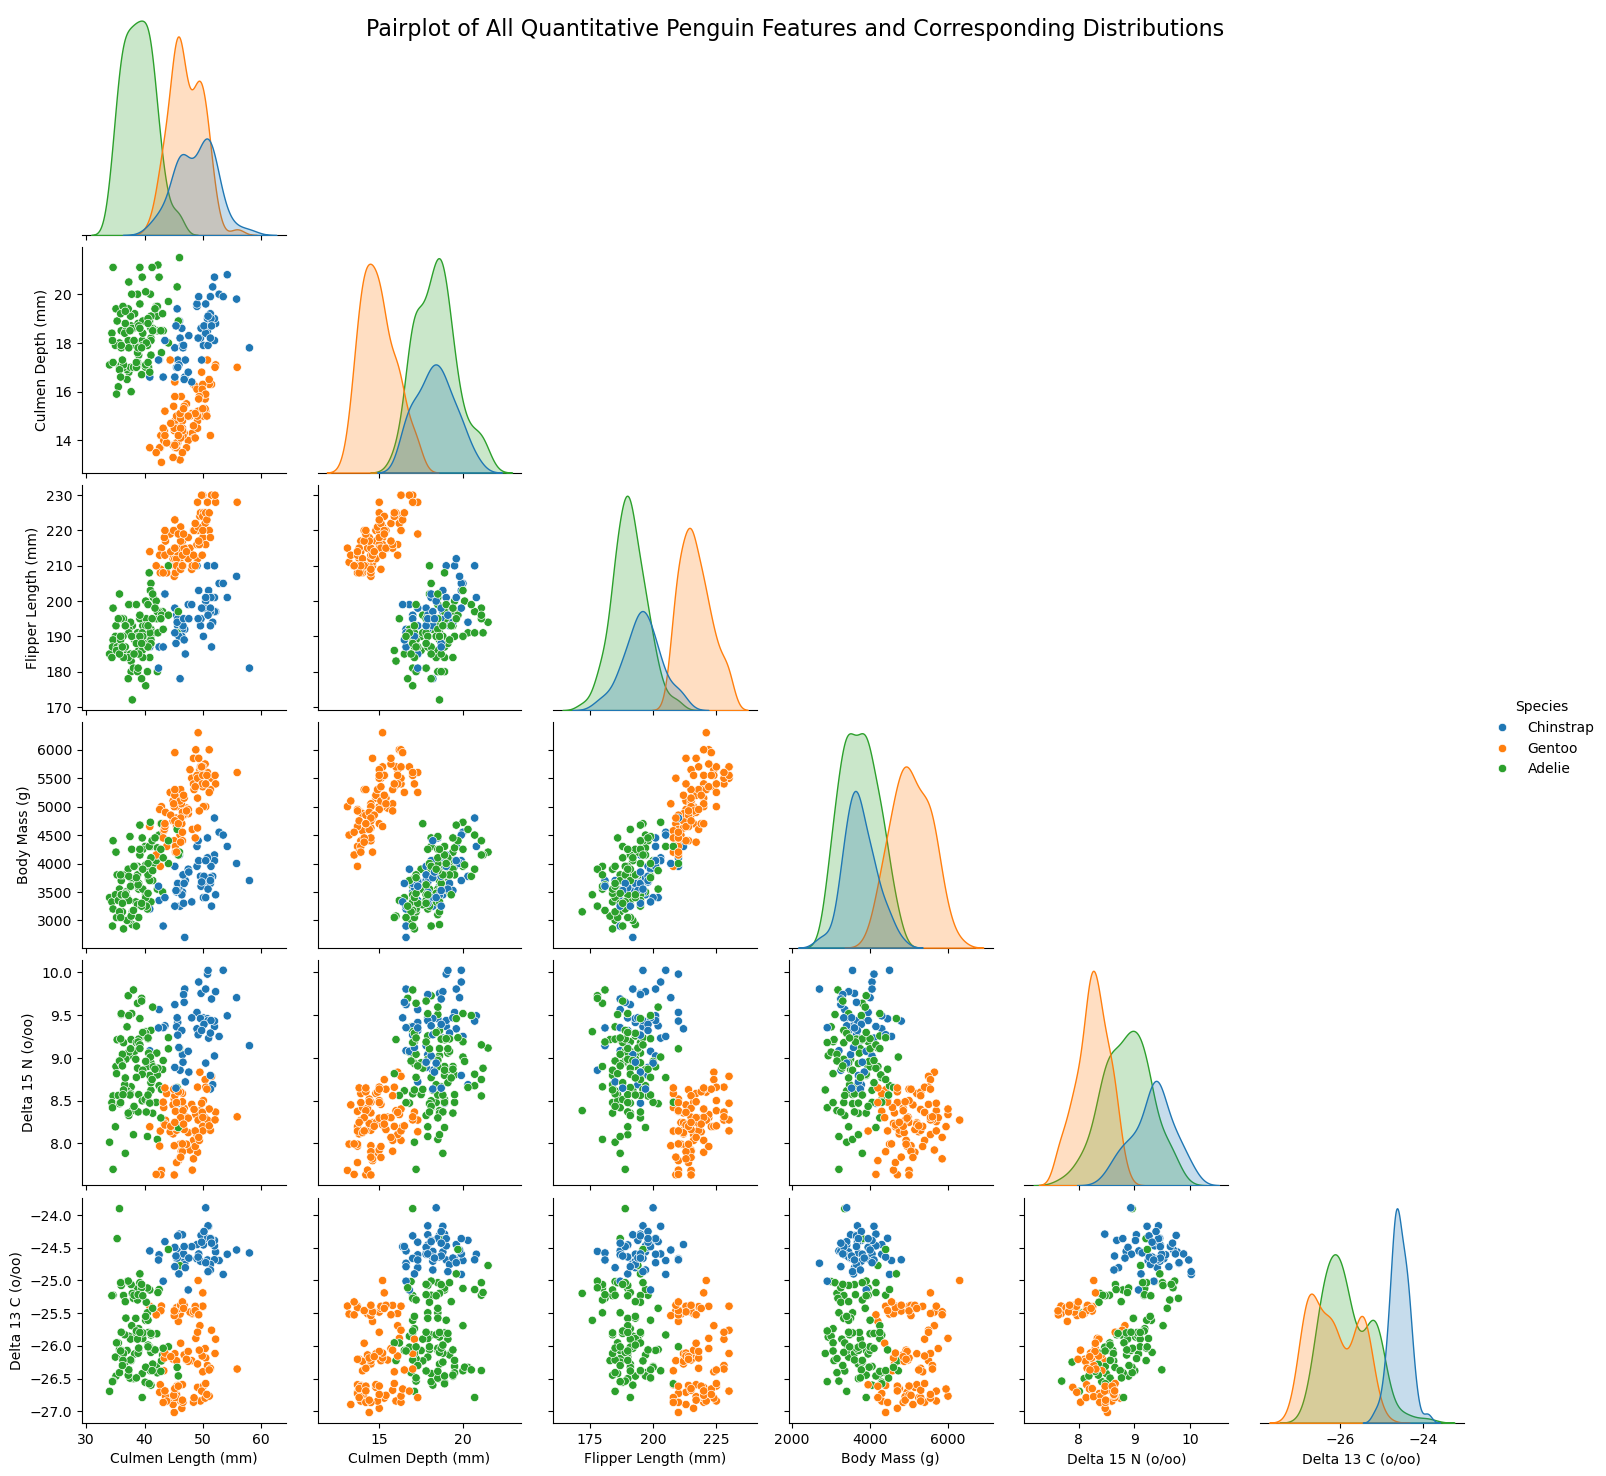

In [6]:
pairplot = sns.pairplot(X_train_visualize[["Culmen Length (mm)", 
                                "Culmen Depth (mm)", 
                                "Flipper Length (mm)", 
                                "Body Mass (g)", 
                                "Delta 15 N (o/oo)", 
                                "Delta 13 C (o/oo)", 
                                "Species"]], 
                                hue = "Species", 
                                palette = "tab10",
                                corner=True)


pairplot.figure.suptitle("Pairplot of All Quantitative Penguin Features and Corresponding Distributions",
                         fontsize = 16)
plt.show()

### Discussion:

Above we have used the Seaborn pairplot function to plot pairwise relationships between all quantitative features in our penguins training data set. Using Pandas fancy indexing, I have selected only the quantitative data in order to **A.)** limit the number of pairs plotted, as including qualitative data could make an excessively large figure, and **B.)** when I tried with qualitative data, data-points became so clustered around the limited values for each of those features - i.e. they would cluster around True and False in linear blobs - which made it very hard to distinguish between entries. While this visualization doesn't necessarily offer a clear choice for optimal features - those features that would be "best" to fit a model on - it can at least offer some insight into where the penguin features experience overlap across species. If you are working with larger data sets, this may be a helpful first step in allowing the Data Scientist to get a "functional sense" of which entries may be productive to focus processing on, and eliminate early on unhelpful feature combinations which could speed up cross-validation/feature selection later down the line.

## Figure 2: Looking for Potential Biases in our Data Set

*Given that the above figure provides a pretty comprehensive look at our feature pairs, I thought it would be helpful to turn towards penguin counts to see if there might be biases in our data set. In other words, are there equal data points for each penguin species we are classifying/predicting?*

<Axes: xlabel='Species', ylabel='Count'>

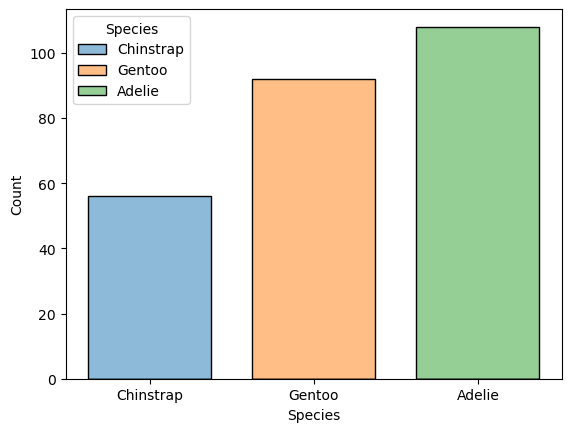

In [7]:
sns.histplot(X_train_visualize, x = "Species", hue = "Species", shrink = .75)

### Discussion:

While this may seem to be a fairly simple visualization, I'd argue that it is one of the most insightful. By showing the count distribution of our penguin species, we begin to see where biases lie in our data set. In the case of the penguins, this means seeing which species are more or less present in the training dataset. If there is a dramatic difference between our different species, this means that we might run the risk of building a prediction model which performs unevenly across new samples. For example, it may be more poorly trained on Chinstrap penguins since there is a far lower count - and thus fewer data points to fit a model on - which could lead to incorrect predictions on future Chinstrap Penguins whose features fall outside the decision boundaries of our model. As such, the we should be wary of the difference between Gentoo and Adelie counts to Chinstrap, and as such should maybe consider features in which Chinstrap penguins have a higher standard deviation - such as Culmen Length - relative to that of Adelie and Gentoo.

## Figure 3: Summary Table

*With both of previous figures in mind, it might now be helpful to get quantified information about how our feature relate across species and to other features.*

In [8]:
X_train_visualize.groupby("Species")[["Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)", "Body Mass (g)", "Delta 15 N (o/oo)", "Delta 13 C (o/oo)"]].aggregate(["std", "mean"])

Culmen Length (mm)            Culmen Depth (mm)             \
                         std       mean               std       mean   
Species                                                                
Adelie              2.685713  38.961111          1.218430  18.380556   
Chinstrap           3.456257  48.771429          1.137935  18.346429   
Gentoo              2.783242  47.133696          1.016336  14.926087   

          Flipper Length (mm)             Body Mass (g)               \
                          std        mean           std         mean   
Species                                                                
Adelie               6.652184  190.527778    462.850335  3722.916667   
Chinstrap            7.366033  195.821429    410.148997  3739.732143   
Gentoo               6.061715  216.739130    498.976123  5057.336957   

          Delta 15 N (o/oo)           Delta 13 C (o/oo)             
                        std      mean               std       mean  
Species                                                             
Adelie             0.428454  8.861431          0.567815 -25.808814  
Chinstrap          0.370290  9.331004          0.224608 -24.567075  
Gentoo             0.282566  8.252573          0.561689 -26.145754

### Discussion:

The above summary table shows the standard deviation and mean of all *quantitative* features in our data set, across the three species of penguins. This is again offers important insight into the breadth of our data points - how much variation we might find in a feature for a specific penguin species - and how each species' feature sets might relate to one another - that is how close is the average culmen length for an Adelie penguin vs. a Gentoo penguin. Features which a higher standard deviation indicates that the data set might cover a wider/more representative portion of the species population, which could mean stronger predictions, but it could also mean more overlap with other species on that feature. This is pretty relative to the mean of those features, of course, but nonetheless offers an important reminder that there isn't one "ideal" standard deviation. Instead, we must always consider it as a statistical value relative to the goal of our model and the context of our dataset. Additionally, features with a similar mean across species could indicate overlap in the data set, meaning it may not be the most optimal feature to fit our model on. 

From this data - which is visualized by the corresponding distributions on the diagonal of Figure 1 - we can see there are some sections of our data with significant overlap across species. This means it would not be best to build a model on these feature combinations.

## Figure 4 (After the Fact)

*Having noticed that a qualitative feature was used to build our model, I wanted to see if there was some way that I could have visualized the quantitative data before building the model to see which feature - Sex or Clutch Completion - would be more helpful than the other.*

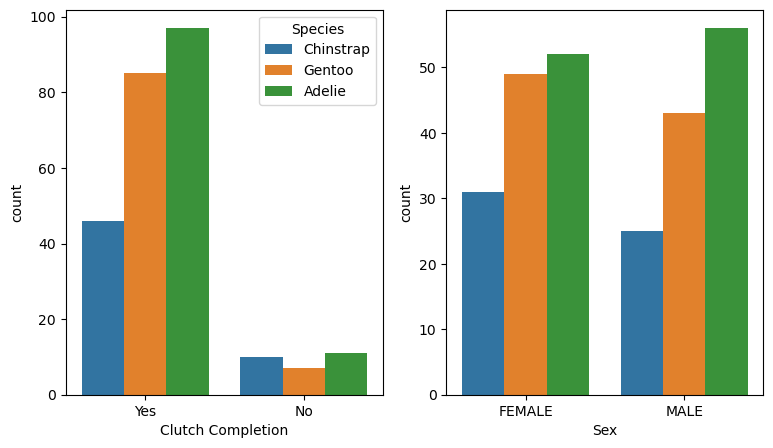

In [9]:
fig, ax = plt.subplots(1, 2, figsize = (9, 5))

p1 = sns.countplot(X_train_visualize, x = "Clutch Completion", hue = "Species", ax = ax[0])
p1 = sns.countplot(X_train_visualize, x = "Sex", hue = "Species", ax = ax[1], legend=False)

### Discussion: (Extra - not part of original three visualizations)

After completing the blog post, I returned to the data exploration/visualization. I was curious about how - considering the fact that clutch completion made it to our "optimal" feature set for classification - we could/would be able to predict if a qualitative feature would be part of our model's feature set? So, while I tried a variety of different plotting functions, this was the best or really most useful visualization I could come up with, a simple count plot. Considering the fact that Clutch Completion made it to the classifier, I don't see anything that would indicate it to be a strong distinguishing feature across the data set. All penguins have far more successful clutch completions (Yes entries) than not (No entries). Ultimately, this shows that the power of our model isn't in single feature classifications, but in being able to compute *the relationship* between features across our data set.

## Building The Model

*Moving now to part two, we need to actually build our model using features from the data set*

In [10]:

le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

*Now that I have pre-processed the data, it's time to determine which features will be used to build our model. Here we take a bit of a long approach, iterating through a variety of feature combinations and seeing which set has the best cross-validation score when fit by a Logistic Regression model.*

*Before processing the data, I decided to scale the quantitative features in order to speed up 
the computations. This process is result of receiving consistent warnings about max_iterations, and code remaining too slow even when the max_iter parameter on my LogisticRegression() constructor was set to 10,000. The warning produced this link:
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler*

*As such, I have included the StandardScaler() object and scaled/transformed my data as per the instructions on the linked page.*

In [11]:
# Cross Validations
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# All feature columns
all_qual_cols = ["Clutch Completion", "Sex"]
all_quant_cols = ['Culmen Length (mm)', 
                  'Culmen Depth (mm)', 
                  'Flipper Length (mm)', 
                  'Body Mass (g)', 
                  'Delta 15 N (o/oo)', 
                  'Delta 13 C (o/oo)']

# Initialize array for optimal columns and variable to store cross-validation
# score for the optimal columns
optimal_columns = []
best_LR_cv_score = 0

# Scale data to facilitate a clean cross-validation process
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[['Culmen Length (mm)', 
                'Culmen Depth (mm)', 
                'Flipper Length (mm)', 
                'Body Mass (g)', 
                'Delta 15 N (o/oo)', 
                'Delta 13 C (o/oo)']] = scaler.fit_transform(X_train_scaled[['Culmen Length (mm)', 
                                                                              'Culmen Depth (mm)', 
                                                                              'Flipper Length (mm)', 
                                                                              'Body Mass (g)', 
                                                                              'Delta 15 N (o/oo)', 
                                                                              'Delta 13 C (o/oo)']])

for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = qual_cols + list(pair)
    LR = LogisticRegression()
    cv_scores_LR = cross_val_score(LR, X_train_scaled, y_train, cv=5)
    cv_scores_mean = cv_scores_LR.mean()
    if cv_scores_mean > best_LR_cv_score:
      best_LR_cv_score = cv_scores_mean
      optimal_columns = cols

print(f"The highest Cross-Validation Score for Logistic Regression was {best_LR_cv_score} \nIt was modeled on the following features: \n{optimal_columns}")



The highest Cross-Validation Score for Logistic Regression was 0.996078431372549 
It was modeled on the following features: 
['Clutch Completion_No', 'Clutch Completion_Yes', 'Culmen Length (mm)', 'Culmen Depth (mm)']


*Having identified our "optimal columns" - i.e. those with the best cross-validation score - I now explore how those features score when fit with different models.*

In [12]:
# Cross Validation for SVC
from sklearn.svm import SVC
# Define range of gamma values (as suggested in blog post assignment)
gamma_values = 10.0**np.arange(-10, 10)

best_svc_cv_score = 0
optimal_gamma = 0.0

for gamma in gamma_values:
    svc = SVC(gamma = gamma)
    cv_scores_svc = cross_val_score(svc, X_train[optimal_columns], y_train, cv=5)
    cv_scores_mean = cv_scores_svc.mean()
    if cv_scores_mean > best_svc_cv_score:
        best_svc_cv_score = cv_scores_mean
        optimal_gamma = gamma
        

print(f"The highest Cross-Validation Score for SVC was {best_svc_cv_score} \nIt was calculated with a gamma of {optimal_gamma}")


The highest Cross-Validation Score for SVC was 0.9491704374057315 
It was calculated with a gamma of 0.1


In [13]:
# Cross Validation for Decision Tree
from sklearn.tree import DecisionTreeClassifier
# Define range of gamma values (as suggested in blog post assignment)
depth_values = np.arange(1, 20)

best_DT_cv_score = 0
optimal_depth = 0

for depth in depth_values:
    DT = DecisionTreeClassifier(max_depth = depth)
    cv_scores_DT = cross_val_score(DT, X_train[optimal_columns], y_train, cv=5)
    cv_scores_mean = cv_scores_DT.mean()
    if cv_scores_mean > best_DT_cv_score:
        best_DT_cv_score = cv_scores_mean
        optimal_depth = depth
        

print(f"The highest Cross-Validation Score for Decision Tree was {best_DT_cv_score} \nIt was calculated with a max depth of {optimal_depth}")


The highest Cross-Validation Score for Decision Tree was 0.9452488687782805 
It was calculated with a max depth of 9


In [14]:
# Cross Validation for Random Forest
from sklearn.ensemble import RandomForestClassifier
# Define range of gamma values (as suggested in blog post assignment)
depth_values = np.arange(1, 20)

best_RF_cv_score = 0
optimal_depth = 0

for depth in depth_values:
    RF = RandomForestClassifier(max_depth = depth)
    cv_scores_RF = cross_val_score(RF, X_train[optimal_columns], y_train, cv=5)
    cv_scores_mean = cv_scores_RF.mean()
    if cv_scores_mean > best_RF_cv_score:
        best_RF_cv_score = cv_scores_mean
        optimal_depth = depth
        

print(f"The highest Cross-Validation Score for Random Forest was {best_RF_cv_score} \nIt was calculated with a max depth of {optimal_depth}")


The highest Cross-Validation Score for Random Forest was 0.9491704374057315 
It was calculated with a max depth of 9


## Evaluate

*With our features chosen as well as our model - Logistic Regression - it is time to evaluate and test our model to see how well it performed*

### Plotting Decision Regions

In [16]:
# Preprocessing: Scale my data, leaving qualitative features alone
scaler = StandardScaler()
optimal_X_train_scaled = X_train[optimal_columns].copy()
optimal_X_train_scaled[["Culmen Length (mm)", "Culmen Depth (mm)"]] = scaler.fit_transform(optimal_X_train_scaled[["Culmen Length (mm)", "Culmen Depth (mm)"]])

# Swap qualitative and quantitative to fit function provided on assignment
plottable_opt_x_train_scaled = optimal_X_train_scaled[["Culmen Length (mm)", "Culmen Depth (mm)", "Clutch Completion_No", "Clutch Completion_Yes"]]

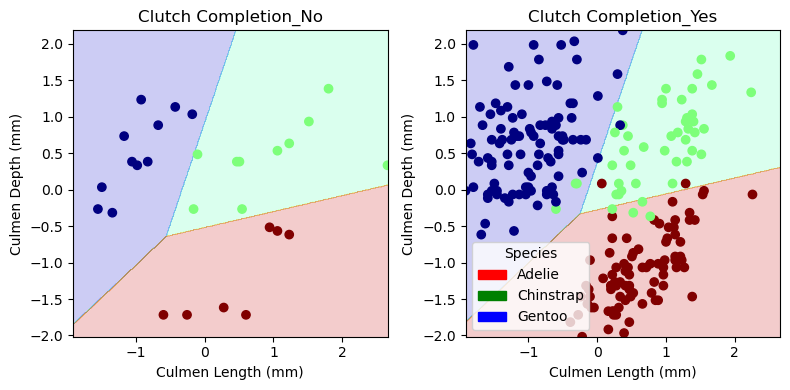

In [17]:
from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (8, 4))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

LR = LogisticRegression()
LR.fit(plottable_opt_x_train_scaled, y_train)
plot_regions(LR, plottable_opt_x_train_scaled, y_train)

## Testing & Confusion Matrix

In [20]:
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

X_test, y_test = prepare_data(test)

# Preprocess
scaler = StandardScaler()
X_test = X_test[optimal_columns].copy()
X_test[["Culmen Length (mm)", "Culmen Depth (mm)"]] = scaler.fit_transform(X_test[["Culmen Length (mm)", "Culmen Depth (mm)"]])

In [21]:
# Produce a Confusion Matrix
from sklearn.metrics import confusion_matrix

LR = LogisticRegression()
LR.fit(optimal_X_train_scaled, y_train)

y_test_pred = LR.predict(X_test)
C = confusion_matrix(y_test, y_test_pred)
C

array([[31,  0,  0],
       [ 1, 10,  0],
       [ 0,  0, 26]])

In [22]:
# Print what each value in the Confusion Matrix represents in the context of our data
for i in range(3):
    for j in range(3):
        print(f"There were {C[i,j]} {le.classes_[i]} penguin(s) who were classified as {le.classes_[j]}.")

There were 31 Adelie Penguin (Pygoscelis adeliae) penguin(s) who were classified as Adelie Penguin (Pygoscelis adeliae).
There were 0 Adelie Penguin (Pygoscelis adeliae) penguin(s) who were classified as Chinstrap penguin (Pygoscelis antarctica).
There were 0 Adelie Penguin (Pygoscelis adeliae) penguin(s) who were classified as Gentoo penguin (Pygoscelis papua).
There were 1 Chinstrap penguin (Pygoscelis antarctica) penguin(s) who were classified as Adelie Penguin (Pygoscelis adeliae).
There were 10 Chinstrap penguin (Pygoscelis antarctica) penguin(s) who were classified as Chinstrap penguin (Pygoscelis antarctica).
There were 0 Chinstrap penguin (Pygoscelis antarctica) penguin(s) who were classified as Gentoo penguin (Pygoscelis papua).
There were 0 Gentoo penguin (Pygoscelis papua) penguin(s) who were classified as Adelie Penguin (Pygoscelis adeliae).
There were 0 Gentoo penguin (Pygoscelis papua) penguin(s) who were classified as Chinstrap penguin (Pygoscelis antarctica).
There were

## Final Discussion:

This blog post taught me that, in a way, constructing predictive models is not a *purely* objective science. While the operations and computations encountered along the way are fundamentally based on logic, the problem of prediction is deeply shaped by the context of the data and the data scientist. At the end of the day the limitations of hardware, software, and our implementations of the algorithmic world cannot - or at least have not yet - account for all the variability in the physical world: The realm of computational classification and prediction is but a finite set of instructions to put together a puzzle of infinite possibilities! Even though the model I coded scored well on the test data, my capacity to correctly predict future penguin species is still constrained: 1 penguin incorrectly predicted still means the model is not perfect. Furthermore, it was trained on much fewer Chinstrap penguins than Adelie or Gentoo, which means I might run a greater risk of mis-predicting Chinstrap penguins down the line. Even more, though it scored well on the test data, that is still only a fraction of penguins that there are out there to predict: there is not necessarily a guarantee that my model will continue to predict at such a high level. This isn't to take away from the performance of the model, or the power of prediction, but more a matter of respecting the dynamism of the physical world. If I have taken anything away from the blog post, it's that we must look to build models in such a way that respects this truth.